Several branches corresponding to different models are created on the following github page:
https://github.com/kcirtap2014/question_categorizer

This branch is different in the corpus creation, we create the corpus out of the tags in the train set. 
Only from train set because otherwise we would have commited some data leakage.

In [1]:
import os
import pandas as pd
import seaborn as sns
import string
import re
from collections import defaultdict
from helper_functions import (group_sort, unique_values, freq_stats_corpora, 
                              evaluate, ngram, jaccard_distance, 
                              cosine_similarity, check_similar_tags, 
                              get_best_tags, CrossValidation)


sns.set_style("white")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Mission
Développer un système de suggestion de tag pour le site stackoverflow

# Load Data

In [2]:
cur_dir = os.path.dirname(os.getcwd())
num_db = 6
df = pd.DataFrame([])

for i in range(num_db):
    df = df.append(
        pd.read_csv(
            cur_dir + "/db/QueryResults%d.csv" % (i + 1), index_col=0))

In [3]:
df.shape

(300000, 21)

In [4]:
df_reduced = df.sample(50000, random_state=23)

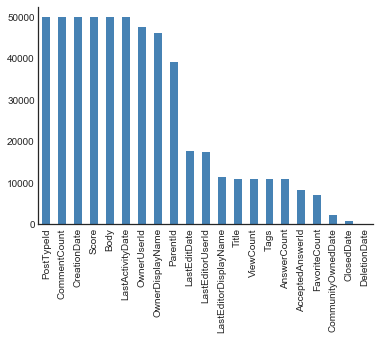

In [5]:
df_count = df_reduced.count().sort_values(ascending=False)
fig, ax = plt.subplots()
df_count.plot.bar(color="steelblue", ax=ax)
sns.despine()

__Observation__:
- Each post has an id, PostTypeId, CommentCount, CreationDate, Score and LastActivityDate
- User information are given by OwnerUserId and OwnerDisplayName, almost all posts are given by distinct user.
- Tags have a significant missing values -> users do not tag much

Here, we are interested in analysing the title and body and then suggest tags to users.

In the *unsupervised learning*, tags are not necessary, but in *supervised learning*, tags are the target variable.

In [6]:
# Combine columns
# add an empty space for distinction
df_text = pd.DataFrame(list(zip(df_reduced.Title,
                                df_reduced.Body)), index = df_reduced.index).rename(columns={
                                    0: 'TITLE',
                                    1: 'BODY',
                                })

In [7]:
def stringbetweencode(data):
    p = re.compile("<code>(.+?)<\/code>", flags=re.DOTALL)
    return p.findall(data) 

def tag_between_brackets(data):
    if pd.notnull(data):
        p = re.compile(r'<(.*?)>')
        return p.findall(data)
    return data

#df_text["CODE"] = np.nan
df_text["CODE"] = df_text["BODY"].apply(stringbetweencode) 
df_text["TAGS"] = df_reduced["Tags"].apply(tag_between_brackets) 

# EDA for Tags

## Tags frequencies analysis

In [8]:
from nltk import FreqDist
from nltk.tokenize import word_tokenize

df_tags = df_text[df_text.TAGS.notnull()]["TAGS"]

# combine all tokens together for freq dist
tagslist = df_tags.sum()

# count frequency of each tag
# How many documents are tagged with a specific tag?
tagsfreq = FreqDist(tagslist)

In [9]:
from operator import itemgetter
# sort by values in descending order
sorted_tagsfreq = sorted(tagsfreq.items(), key=itemgetter(1), reverse=True)
tags_key, tags_value = zip(*sorted_tagsfreq)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


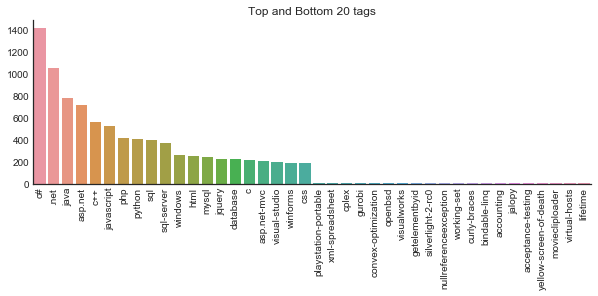

In [10]:
# prepare for sns.barplot
fig, ax = plt.subplots( figsize=(10, 3))

n_element = 20
x_tags = np.array(tags_key[:n_element]+ tags_key[-n_element:])
y_tags = np.array(tags_value[:n_element]+ tags_value[-n_element:])
sns.barplot(x_tags, y_tags, ax=ax)
ax.set_xticklabels(x_tags, rotation=90)
ax.set_title('Top and Bottom 20 tags')
sns.despine()

In [11]:
pd.Series(tags_value).describe([0.5, 0.75,0.9,0.95])

count    4476.000000
mean        7.005585
std        38.234422
min         1.000000
50%         1.000000
75%         4.000000
90%        10.000000
95%        22.000000
max      1409.000000
dtype: float64

__Observation__:
- 50% of the tags only occur once, we will eliminate tags that have low counts, taking the arg of 75% as threshold

# Text preprocessing with scikit learn and NLTK

In [12]:
from sklearn.decomposition import LatentDirichletAllocation
from nltk import regexp_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pdb

wnl = WordNetLemmatizer()

def convert_tag(tag):
    """
    Convert the tag given by nltk.pos_tag 
    to the tag used by wordnet.synsets
    """
    tag_dict = {'N': 'n', 'J': 'a', 'R': 'r', 'V': 'v'}
    try:
        return tag_dict[tag[0]]
    except KeyError:
        # defalut value
        return 'n'  #None


def lemmatizer(doc):
    """
    returns lemmatized tokens after removing stop words and pos tagging
    
    Parameters:
    -----------
    doc: pandas dataframe
        text description in df
    
    Return:
    -------
    pandas dataframe
        lemmatized, pos_tagged, and removed stopwords tokens
    """
    if pd.notnull(doc):
        # add words to stoplist, previously punctuations have been removed,
        # so we should do the same for the stoplist
        stoplist = [striphtmlpunct(x)
                    for x in stopwords.words('english')] + ['im', 'ive']
        #stoplist = stopwords.words('english') + [
        #    "i've", "either", "i'm", "i'd", "would", "could", 'it', "like",
        #    "something", "also", "might", "want", 'this', 'make', 'sure'
        #]

        lemmatized = []

        regex_tokens = regexp_tokenize(doc, pattern='\w+\S+|\.\w+')
        
        for word, p_tags in pos_tag(regex_tokens):
            if word not in set(stoplist):
                convert_pos_tag = convert_tag(p_tags)
                lemmatized.append(wnl.lemmatize(word, pos=convert_pos_tag))
   
        return pd.Series(' '.join(lemmatized))
    return pd.Series(doc)


def striphtmlpunct(data):
    # remove html tags, code unnecessary punctuations
    # <.*?> to remove everything between <>
    # [^\w\s+\.\-\#\+] remove punctuations except .-#+
    # (\.{1,3})(?!\S) negative lookahead assertion: only match .{1,3} that
    # is followed by white space
    if pd.notnull(data):
        p = re.compile(r'<.*?>|[^\w\s+\.\-\#\+]')
        res = p.sub('', data)
        pe = re.compile('(\.{1,3})(?!\S)')
        
        return pe.sub('', res)
    
    return data


def striptabs(data):
    # remove tabs breaklines
    p = re.compile(r'(\r\n)+|\r+|\n+|\t+/i')
    return p.sub(' ', data)

def lower(data):
    if pd.notnull(data):
        return data.lower()
    return data


# remove html tags
df_text["BODY_STRIPPED"] = df_text.BODY.apply(lower).apply(
    striphtmlpunct).apply(striptabs)
df_text["CODE_STRIPPED"] = df_text.CODE.apply(
    lambda x: [striptabs(line.lower()) for line in x if x])
df_text["TITLE_STRIPPED"] = df_text.TITLE.apply(lower).apply(striphtmlpunct)

# remove stop words, pos_tag, and lemmatize
df_text["BODY_LEMMATIZED"] = df_text["BODY_STRIPPED"].apply(lemmatizer)
df_text["TITLE_LEMMATIZED"] = df_text["TITLE_STRIPPED"].apply(lemmatizer)

In [13]:
df_text.head()

,TITLE,BODY,CODE,TAGS,BODY_STRIPPED,CODE_STRIPPED,TITLE_STRIPPED,BODY_LEMMATIZED,TITLE_LEMMATIZED
Id,,,,,,,,,
401982,NaN,<h2>Re Is cut-and-past ever acceptable:</h2>\n...,[private static final String EMPLOYEE_COLUMNS ...,NaN,re is cut-and-past ever acceptable yes when th...,[private static final string employee_columns ...,NaN,cut-and-past ever acceptable yes segment sligh...,NaN
109829,NaN,<p>You need to start further down the line. Yo...,[],NaN,you need to start further down the line you ne...,[],NaN,need start line need know container format spe...,NaN
552890,What do you think about the new Debian release...,<p>I was surprised to know that Lenny already ...,[],"[linux, unix, debian, release-cycle]",i was surprised to know that lenny already pro...,[],what do you think about the new debian release...,surprise know lenny already promote stable amo...,think new debian release cycle
236203,"Why does a h1 tag display different in a div, ...",<p>I have a div with a <code>&lt;h1&gt;</code>...,"[&lt;h1&gt;, &lt;h1&gt;, &lt;!DOCTYPE HTML PUB...","[html, css]",i have a div with a lth1gt tag in a div with n...,"[&lt;h1&gt;, &lt;h1&gt;, &lt;!doctype html pub...",why does a h1 tag display different in a div w...,div lth1gt tag div margin define doctype white...,h1 tag display different div doctype set
138781,NaN,<p>A while back I did a how-to blog post on us...,[],NaN,a while back i did a how-to blog post on using...,[],NaN,back how-to blog post use svn one developer ca...,NaN


### Eliminate entries without tags
- since we have remove low count tags, some entries will be tagless, we remove these entries for supervised learning 

In [14]:
df_text_reduced = df_text.loc[df_tags.index]

In [15]:
df_text_reduced.sample(3, random_state=344)

,TITLE,BODY,CODE,TAGS,BODY_STRIPPED,CODE_STRIPPED,TITLE_STRIPPED,BODY_LEMMATIZED,TITLE_LEMMATIZED
Id,,,,,,,,,
411457,How to refresh a simple binding of a Windows F...,<p>I'm binding a domain objects property to th...,"[DataBindings, Label l = new Label();\nl.DataB...","[c#, .net, binding]",im binding a domain objects property to the te...,"[databindings, label l = new label(); l.databi...",how to refresh a simple binding of a windows f...,bind domain object property text property syst...,refresh simple binding window form control
302637,How to resolve AIX tar command sockets errors?,"<p>Working in an AIX environment, I'm issuing ...",[ $ tar -cvf /post_patches.tar /xyz \n tar:...,"[linux, unix, aix, tar]",working in an aix environment im issuing the f...,[ $ tar -cvf /post_patches.tar /xyz tar: ...,how to resolve aix tar command sockets errors,work aix environment issue following tar comma...,resolve aix tar command socket error
301224,Using Web Browser as a Thin Client to Access c...,"<p>I have an ASP.NET MVC application, when a u...",[],"[asp.net-mvc, architecture]",i have an asp.net mvc application when a user ...,[],using web browser as a thin client to access c...,asp.net mvc application user click submit butt...,use web browser thin client access certain app...


In [16]:
df_text_reduced.iloc[39].BODY

"<p>A service I have in WCF occasionally goes down due a problem with a COM component. While I am troubleshooting I would like to setup another host to make regular calls to this service to monitor availability.</p>\n\n<p>It is slightly more complicated that a simple HTTP call though as the service is secured by SSL and WCF authentication (username / password). I'd also like to be able to parse successful calls to see if they return warning / fail states from my code.</p>\n\n<p>Would you recommend any monitoring providers for this or is it beyond the simple monitoring they normally provide?</p>\n\n<p>Regards</p>\n\n<p>Ryan</p>\n"

In [17]:
df_text_reduced.iloc[39].BODY_STRIPPED

'a service i have in wcf occasionally goes down due a problem with a com component while i am troubleshooting i would like to setup another host to make regular calls to this service to monitor availability it is slightly more complicated that a simple http call though as the service is secured by ssl and wcf authentication username  password id also like to be able to parse successful calls to see if they return warning  fail states from my code would you recommend any monitoring providers for this or is it beyond the simple monitoring they normally provide regards ryan '

In [18]:
df_text_reduced.iloc[39].BODY_LEMMATIZED

'service wcf occasionally go due problem com component troubleshoot would like setup another host make regular call service monitor availability slightly complicated simple http call though service secure ssl wcf authentication username password id also like able parse successful call see return warn fail state code would recommend monitoring provider beyond simple monitoring normally provide regard ryan'

## Eliminate low count tags

In [19]:
def remove_low_count_tags(data, tags_key=None):

    reduced = []
    for el in data:
        if el in set(tags_key):
            reduced.append(el)

    if not reduced:
        reduced = np.NaN

    return reduced


# combine all tokens together for freq dist
tagslist_reduced = df_text_reduced.TAGS.sum()

# count frequency of each tag
# How many documents are tagged with a specific tag?
tagsfreq_reduced = FreqDist(tagslist_reduced)
sorted_tagsfreq_reduced = sorted(
    tagsfreq_reduced.items(), key=itemgetter(1), reverse=True)
tags_key_reduced, tags_value_reduced = zip(*sorted_tagsfreq_reduced)

# drop keywords that have less than tag_freq
quartile = 0.95
n_tag = pd.Series(tags_value_reduced).quantile([quartile]).values[0]
sorted_tagsfreq_reduced_quartile = [
    el for el in sorted_tagsfreq_reduced if el[1] > n_tag
]
tags_key_reduced_quartile, tags_value_reduced_quartile = zip(
    *sorted_tagsfreq_reduced_quartile)
df_tags_temp = df_text_reduced.TAGS.apply(
    remove_low_count_tags, tags_key=tags_key_reduced_quartile)
df_text_reduced["TAGS_MODIFIED"] = df_tags_temp
df_tags_reduced = df_text_reduced[df_text_reduced.TAGS_MODIFIED.notnull()]


In [20]:
print("%.1f%% of the data are retained" %(100*len(df_tags_reduced)/len(df_tags)))

91.8% of the data are retained


## Tags similarity
### Comparison between Cosine similarity and Jaccard distance


In [21]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
selection_threshold =0.5

sim_word_cosine = defaultdict(list)
sim_word_jaccard = defaultdict(list)

for i in range(len(tags_key_reduced_quartile)):
    for j in range(len(tags_key_reduced_quartile)):
        word_i = tags_key_reduced_quartile[i]
        word_j = tags_key_reduced_quartile[j]
        
        # Porter stem to avoid matching words that have the same ending
        # such as serialization, internationalization
        word_i_lem = stemmer.stem(word_i)
        word_j_lem = stemmer.stem(word_j)
        
        # generation of trigrams
        trigrams_i = ngram(word_i_lem, 3)
        trigrams_j = ngram(word_j_lem, 3)

        cosine_sim = cosine_similarity(trigrams_i, trigrams_j)
        jaccard_sim = jaccard_distance(trigrams_i, trigrams_j)

        if cosine_sim >= selection_threshold and cosine_sim < 0.98:
            sim_word_cosine[tags_key_reduced_quartile[i]].append({
                tags_key_reduced_quartile[j]:
                cosine_sim
            })

        if jaccard_sim >= selection_threshold and jaccard_sim < 1.:
            sim_word_jaccard[tags_key_reduced_quartile[i]].append({
                tags_key_reduced_quartile[j]:
                jaccard_sim
            })

#### Use graph from network x to store associations

In [22]:
# Create a dataframe to illustrate the differences
df_tags_sim = pd.DataFrame()

for key, values in sim_word_cosine.items():
    for i in range(len(sim_word_cosine[key])):
        try:
            jaccard_entry = list(sim_word_jaccard[key][i].keys())[0]
        except IndexError:
            jaccard_entry = np.NaN

        try:
            cosine_entry = list(sim_word_cosine[key][i].keys())[0]
        except IndexError:
            cosine_entry = np.NaN
            
        df_tags_sim = df_tags_sim.append(
            {
                "TAG": key,
                "TAG_JACCARD": jaccard_entry,
                "TAG_COSINE": cosine_entry
            },
            ignore_index=True)

In [23]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# use a bidirectional graph
G_tags = nx.Graph()
node2link = zip(df_tags_sim.TAG, df_tags_sim.TAG_COSINE)
G_tags.add_nodes_from(list(df_tags_sim.TAG))
G_tags.add_edges_from(node2link)
info = nx.info(G_tags)

In [24]:
print(info)

Name: 
Type: Graph
Number of nodes: 80
Number of edges: 73
Average degree:   1.8250


In [25]:
df_tags_sim.head(10)

,TAG,TAG_COSINE,TAG_JACCARD
0,.net,asp.net,vb.net
1,.net,vb.net,NaN
2,.net,.net-3.5,NaN
3,.net,.net-2.0,NaN
4,.net,ado.net,NaN
5,java,java-ee,java-ee
6,asp.net,.net,asp.net-mvc
7,asp.net,asp.net-mvc,asp.net-ajax
8,asp.net,asp.net-ajax,NaN
9,javascript,scripting,scripting


## Bag-of-words distribution associated to a tag

### On text title

In [26]:
df_text_reduced_tokens = df_text_reduced.loc[
    :, "TITLE_LEMMATIZED"].apply(lambda x: x.split())
df_tags_title = pd.DataFrame(
    list(zip(df_tags_reduced.TAGS_MODIFIED,
             df_text_reduced_tokens))).rename(columns={
                 0: "elkey",
                 1: "elvalue"
             })

In [27]:
corpfreq_title, corpstats_title, corpora_title = freq_stats_corpora(
    df_tags_title)

In [28]:
# sort by values in descending order
sorted_corpfreq_title = defaultdict(list)
cutoff = 10

for tag, tagfreq in corpfreq_title.items():
    # only add into sorted_corpfreq if the word occurencces are>50
    if sum(list(tagfreq.values())) > cutoff:
        sorted_corpfreq_title[tag] = sorted(
            tagfreq.items(), key=itemgetter(1), reverse=True)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


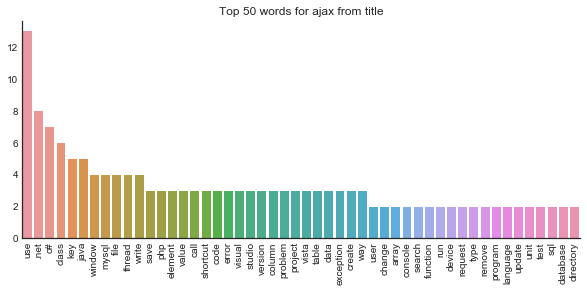

In [29]:
token_index = 10
key = list(sorted_corpfreq_title.keys())[token_index]
corptags_key_title, corptags_value_title = zip(*sorted_corpfreq_title[key])
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(corptags_key_title[:n_element]),
    np.array(corptags_value_title[:n_element]),
    ax=ax)
ax.set_xticklabels(corptags_key_title[:n_element], rotation=90)
ax.set_title('Top 50 words for %s from title' %key)
sns.despine()

### On text body

In [30]:
df_body_reduced_tokens = df_text_reduced.loc[
    :, "BODY_LEMMATIZED"].apply(lambda x: x.split())

df_tags_body = pd.DataFrame(
    list(
        zip(df_tags_reduced.TAGS_MODIFIED,
            df_body_reduced_tokens))).rename(
                columns={
                    0: "elkey",
                    1: "elvalue"
                })

In [31]:
corpfreq_body, corpstats_body, corpora_body = freq_stats_corpora(df_tags_body)

In [32]:
# sort by values in descending order
sorted_corpfreq_body = defaultdict(list)
cutoff = 1
cutoff_doc = 50
n_most_common = 20
# most frequent words will be the corpora that we use as a dictionary
most_frequent_words = defaultdict(list)

for tag, tagfreq in corpfreq_body.items():
    # only add into sorted_corpfreq if the word occurencces > cutoff_doc
    if sum(list(tagfreq.values())) > cutoff_doc:
    
        most_frequent_words[tag] = set(
            i[0] for i in tagfreq.most_common(n_most_common) if i[1] > cutoff)
        sorted_corpfreq_body[tag] = sorted(
            tagfreq.items(), key=itemgetter(1), reverse=True)


/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


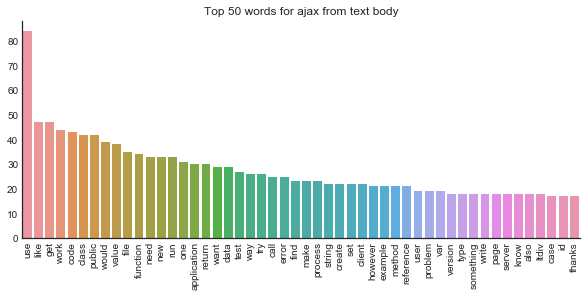

In [33]:
token_index = 10
key = list(sorted_corpfreq_body.keys())[token_index]
corptags_key_body, corptags_value_body = zip(*sorted_corpfreq_body[key])
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(corptags_key_body[:n_element]),
    np.array(corptags_value_body[:n_element]),
    ax=ax)
ax.set_xticklabels(corptags_key_body[:n_element], rotation=90)
ax.set_title(
    'Top 50 words for %s from text body' %key)
sns.despine()

__Observation__:
- From text.body and text.title, the tag words appear the most often in the word distrbution. For example, 
    - {tagword: *python*, word_distrb: {python: 280, way: 120...}
    - {tagword: *performance*, word_distrb: {performance: 120, time: 50...}
    - {tagword: *html*, word_distrb: {html: 150, page: 80...}
- This implies that we can rely on the presence of certain words to correctly predict tags

# Supervised learning: ScikitLearn OneVsRest Classifier

## Use text title only

### Random sampling

In [34]:
df_tags_reduced_sampled = df_tags_reduced.sample(5000, random_state=2)

### Label binarization

In [35]:
from sklearn.preprocessing import MultiLabelBinarizer

lb = MultiLabelBinarizer()
targets = lb.fit_transform(df_tags_reduced_sampled.TAGS_MODIFIED)


### Train/crossval/test split
We create a corpus from the train set. This corpus contains the n most frequent words in each tag. We have seen previously that the tag is often found in the text body.

In [71]:
X_counts = df_tags_reduced_sampled.TITLE_LEMMATIZED \
            +' '+ df_tags_reduced_sampled.BODY_LEMMATIZED

# shuffle indices
idx = np.arange(X_counts.shape[0])
np.random.seed(23)
np.random.shuffle(idx)

# Generate train/crossval/test sets
train_size = int(.8 * X_counts.shape[0])

X_train = X_counts.iloc[idx[:train_size]]
y_train = targets[idx[:train_size],:]
X_test = X_counts.iloc[idx[train_size:]]
y_test = targets[idx[train_size:],:]

### Training with Dummy Classifier (strategy=prior)
__Count vectorizer__ 

In [72]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import jaccard_similarity_score
from sklearn.feature_extraction.text import CountVectorizer

Dummy_pipeline_count = Pipeline([
    ('count', CountVectorizer()),
    ('clf', OneVsRestClassifier(DummyClassifier(strategy='prior'))),
])

Dummy_pipeline_count.fit(X_train, y_train)
# compute the testing accuracy
y_pred_count_dummy = Dummy_pipeline_count.predict(X_test)
y_pred_proba_count_dummy = Dummy_pipeline_count.predict_proba(X_test)
y_pred_new_count_dummy = get_best_tags(y_pred_count_dummy,
                                       y_pred_proba_count_dummy)
test_score_count_dummy = evaluate(
    y_test,
    y_pred_new_count_dummy,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=False)

print('Test score: {}'.format(test_score_count_dummy))

Test score: 0.134


__Tfidf vectorizer__ 

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

Dummy_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(DummyClassifier(strategy='prior'))),
])

Dummy_pipeline_tfidf.fit(X_train, y_train)
# compute the testing accuracy
y_pred_tfidf_dummy = Dummy_pipeline_tfidf.predict(X_test)
y_pred_proba_tfidf_dummy = Dummy_pipeline_tfidf.predict_proba(X_test)
y_pred_new_tfidf_dummy = get_best_tags(y_pred_tfidf_dummy,
                                       y_pred_proba_tfidf_dummy)
test_score_tfidf_dummy = evaluate(
    y_test,
    y_pred_new_tfidf_dummy,
    binarizer=lb,
    G_tags=G_tags,
    l_print_errors=False)

print('Test score: {}'.format(test_score_count_dummy))

Test score: 0.134


### Training with Naive Bayes Classifier
__Count vectorizer__ 

In [74]:
from sklearn.naive_bayes import MultinomialNB

NB_pipeline_count = Pipeline([
    ('count', CountVectorizer()),
    ('clf', OneVsRestClassifier(
        MultinomialNB(fit_prior=True, class_prior=None))),
])

NB_pipeline_count.fit(X_train, y_train)
# compute the testing accuracy
y_pred_count = NB_pipeline_count.predict(X_test)
y_pred_proba_count = NB_pipeline_count.predict_proba(X_test)
y_pred_new_count = get_best_tags(y_pred_count, y_pred_proba_count)
test_score_count, errors_count = evaluate(
        y_test,
        y_pred_new_count,
        binarizer=lb,
        G_tags=G_tags,
        l_print_errors=True)

print('Test score: {}'.format(test_score_count))

Test score: 0.329


__Tfidf vectorizer__

In [75]:
NB_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(
        MultinomialNB(fit_prior=True, class_prior=None))),
])

NB_pipeline_tfidf.fit(X_train, y_train)
# compute the testing accuracy
y_pred_tfidf = NB_pipeline_tfidf.predict(X_test)
y_pred_proba_tfidf = NB_pipeline_tfidf.predict_proba(X_test)
y_pred_new_tfidf = get_best_tags(y_pred_tfidf, y_pred_proba_tfidf)
test_score_tfidf, errors_tfidf = evaluate(
    y_test, y_pred_new_tfidf, binarizer=lb, G_tags=G_tags, l_print_errors=True)

print('Test score: {}'.format(test_score_tfidf))

Test score: 0.173


### Training with SVM
__Count vectorizer__

In [76]:
from sklearn.svm import SVC

# cross validation
crossval = CrossValidation(
    OneVsRestClassifier(SVC(kernel='linear')),
    CountVectorizer, {"C": np.logspace(-2, 1, 4)},
    lb,
    G_tags)
crossval.cv(X_train, y_train)

SVM_pipeline_count = Pipeline([
    ('count', CountVectorizer()),
    ('clf',
     OneVsRestClassifier(SVC(C=crossval.best_parameter_['C']['value']))),
])

print("Best parameter", crossval.best_parameter_)

SVM_pipeline_count.fit(X_train, y_train)
y_pred_svm_count = SVM_pipeline_count.predict(X_test)
y_pred_proba_svm_count = SVM_pipeline_count.decision_function(X_test)
y_pred_new_svm_count = get_best_tags(y_pred_svm_count, y_pred_proba_svm_count)

print('Test score: {}'.format(
    evaluate(
        y_test,
        y_pred_new_svm_count,
        binarizer=lb,
        G_tags=G_tags,
        l_print_errors=False)))

Best parameter {'C': {'value': 0.1, 'mean': 0.6282562019815299}}
Test score: 0.554


__Tfidf vectorizer__

In [77]:
# cross validation
crossval_tfidf = CrossValidation(
    OneVsRestClassifier(SVC(kernel='linear')),
    TfidfVectorizer, {"C": np.logspace(-2, 1, 4)},
    lb,
    G_tags)
crossval_tfidf.cv(X_train, y_train)

SVM_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf',
     OneVsRestClassifier(SVC(C=crossval_tfidf.best_parameter_['C']['value']))),
])

print("Best parameter", crossval_tfidf.best_parameter_)

SVM_pipeline_tfidf.fit(X_train, y_train)
y_pred_svm_tfidf = SVM_pipeline_tfidf.predict(X_test)
y_pred_proba_svm_tfidf = SVM_pipeline_tfidf.decision_function(X_test)
y_pred_new_svm_tfidf = get_best_tags(y_pred_svm_tfidf, y_pred_proba_svm_tfidf)

print('Test score: {}'.format(
    evaluate(
        y_test,
        y_pred_new_svm_tfidf,
        binarizer=lb,
        G_tags=G_tags,
        l_print_errors=False)))

Best parameter {'C': {'value': 1.0, 'mean': 0.6410063910280418}}
Test score: 0.624


## Training with Logistic Regression

__Count vectorizer__

In [78]:
from sklearn.linear_model import LogisticRegressionCV

lr_pipeline_count = Pipeline([
    ('count', CountVectorizer()),
    ('clf',
     OneVsRestClassifier(
         LogisticRegressionCV(
             Cs=np.logspace(-2, 2, 5), dual=True, cv=5, solver='liblinear'))),
])

lr_pipeline_count.fit(X_train, y_train)
y_pred_lr_count = lr_pipeline_count.predict(X_test)
y_pred_proba_lr_count = lr_pipeline_count.decision_function(X_test)
y_pred_new_lr_count = get_best_tags(y_pred_lr_count, y_pred_proba_lr_count)

print('Test score: {}'.format(
    evaluate(
        y_test,
        y_pred_new_lr_count,
        binarizer=lb,
        G_tags=G_tags,
        l_print_errors=False)))

Test score: 0.581


__Tfidf vectorizer__

In [79]:
lr_pipeline_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf',
     OneVsRestClassifier(
         LogisticRegressionCV(
             Cs=np.logspace(-2, 2, 5), dual=True, cv=5, solver='liblinear'))),
])

lr_pipeline_tfidf.fit(X_train, y_train)
y_pred_lr_tfidf = lr_pipeline_tfidf.predict(X_test)
y_pred_proba_lr_tfidf = lr_pipeline_tfidf.decision_function(X_test)
y_pred_new_lr_tfidf = get_best_tags(y_pred_lr_tfidf, y_pred_proba_lr_tfidf)

print('Test score: {}'.format(
    evaluate(
        y_test,
        y_pred_new_lr_tfidf,
        binarizer=lb,
        G_tags=G_tags,
        l_print_errors=False)))

Test score: 0.567


__Observation__:
- SVM with TFIDF vectorizer returns the best test score so far (0.561). 
- Logistic regressions are not that bad either.